In [1]:
import math
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from torch.distributions import Categorical

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch.func as func

torch.set_default_dtype(torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng(123)
torch.manual_seed(123)

import csv

In [2]:
min_position = -0.99
max_position =  0.99
max_speed    =  0.07
dt           =  0.1
force_mag    =  0.001
gravity      =  0.0025

min_start_pos = 0.67
max_start_pos = 0.77
max_start_vel = 0.01

state_low  = torch.tensor([min_position, -max_speed], device=device)
state_high = torch.tensor([max_position,  max_speed], device=device)
box_area   = (max_position - min_position) * (2*max_speed)

def tg_alpha(x):
    return 0.1*(2*x/(1 - x**2) - 2*math.pi*torch.sin(2*math.pi*x) - 8*math.pi*torch.sin(4*math.pi*x))

def total_horizontal_force(a, x):
    return (a*2 - 1)*force_mag + tg_alpha(x)*(-gravity)

def next_state(s, a):
    x = s[:, 0]
    v = s[:, 1]
    f = total_horizontal_force(a.float(), x)
    v = torch.clamp(v + f*dt, -max_speed, max_speed)
    x = torch.clamp(x + v*dt, min_position, max_position)
    return torch.stack([x, v], dim=1)

In [3]:
def sample_proposal(n):
    u = torch.rand(n, 2, device=device)
    s = state_low + u*(state_high - state_low)
    return s

def sample_start(n):
    sign = torch.where(torch.rand(n, device=device) < 0.5, -torch.ones(n, device=device), torch.ones(n, device=device))
    pos = sign*torch.rand(n, device=device)*(max_start_pos - min_start_pos) + sign*min_start_pos
    vel = (torch.rand(n, device=device)*2 - 1)*max_start_vel
    return torch.stack([pos, vel], dim=1)

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self._fc_policy = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self._fc_policy(x)

policy_net = PolicyNetwork().to(device)
state_dict = torch.load(r"D:\python_projects\pythonProject\state_distribution\models\net.pth", map_location=device)
policy_state = OrderedDict({k.replace('_fc_policy.', ''): v for k, v in state_dict.items() if k.startswith('_fc_policy')})
policy_net._fc_policy.load_state_dict(policy_state)
policy_net.eval()

PolicyNetwork(
  (_fc_policy): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [5]:
@torch.no_grad()
def sample_actions(s):
    logits = policy_net(s)
    dist = Categorical(logits=logits)
    return dist.sample()

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, d: int, use_ln: bool = False, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
        self.ln1 = nn.LayerNorm(d) if use_ln else nn.Identity()
        self.ln2 = nn.LayerNorm(d) if use_ln else nn.Identity()
        self.act = nn.SiLU()
        self.fc1 = nn.Linear(d, d)
        self.fc2 = nn.Linear(d, d)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        y = self.act(self.ln1(x))
        y = self.fc1(y)
        y = self.act(self.ln2(y))
        y = self.fc2(y)
        return x + self.alpha * y


class SiLUDensityRes(nn.Module):
    def __init__(self, hidden: int = 256, blocks: int = 5, use_ln: bool = True, box_area: float = 1.0):
        super().__init__()
        self.inp = nn.Linear(2, hidden)
        nn.init.kaiming_normal_(self.inp.weight, nonlinearity='relu')
        nn.init.zeros_(self.inp.bias)

        self.blocks = nn.Sequential(*[ResidualBlock(hidden, use_ln=use_ln, alpha=0.1)
                                      for _ in range(blocks)])

        self.out = nn.Linear(hidden, 1)
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='relu')
        nn.init.zeros_(self.out.bias)

        with torch.no_grad():
            self.out.bias.fill_(-math.log(box_area))

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        h = self.inp(x)
        h = self.blocks(h)
        return self.out(h).squeeze(-1)

    def forward(self, x):
        return self.log_prob(x)

In [10]:
import torch
import math

class RFFSampler2D:
    def __init__(self, 
                 gamma_position=0.1275,
                 gamma_velocity=25.51,
                 lambda_min_pos=0.1,
                 lambda_min_vel=0.007,
                 device=None, 
                 dtype=torch.float32):
        self.device = device or torch.device('cpu')
        self.dtype = dtype
        self.sig_pos_base = torch.tensor(2.0 * gamma_position, device=self.device, dtype=self.dtype).sqrt()
        self.sig_vel_base = torch.tensor(2.0 * gamma_velocity, device=self.device, dtype=self.dtype).sqrt()
        self.sig_pos_max = torch.tensor(math.pi / lambda_min_pos, device=self.device, dtype=self.dtype)
        self.sig_vel_max = torch.tensor(math.pi / lambda_min_vel, device=self.device, dtype=self.dtype)
        self.sig_pos_mid = (self.sig_pos_base * self.sig_pos_max).sqrt()
        self.sig_vel_mid = (self.sig_vel_base * self.sig_vel_max).sqrt()
        print(f"Initialized RFF Sampler with 3 principled bands:")
        print(f"  LOW (Base): sig_pos={self.sig_pos_base.item():.3f}, sig_vel={self.sig_vel_base.item():.3f}")
        print(f"  MID (Mean): sig_pos={self.sig_pos_mid.item():.3f}, sig_vel={self.sig_vel_mid.item():.3f}")
        print(f"  HIGH (Max): sig_pos={self.sig_pos_max.item():.3f}, sig_vel={self.sig_vel_max.item():.3f}")

        self.omegas = None
        self.biases = None

    @torch.no_grad()
    def sample_batch(self, B: int, device=None, dtype=None):
        device = device or self.device
        dtype = dtype or self.dtype
        B1 = B // 3
        B2 = B // 3
        B3 = B - B1 - B2

        def band(sig_pos, sig_vel, K):
            op = torch.normal(0.0, sig_pos, (K,), device=device, dtype=dtype)
            ov = torch.normal(0.0, sig_vel, (K,), device=device, dtype=dtype)
            return torch.stack([op, ov], dim=1)
        O1 = band(self.sig_pos_base, self.sig_vel_base, B1)
        O2 = band(self.sig_pos_mid, self.sig_vel_mid, B2)
        O3 = band(self.sig_pos_max, self.sig_vel_max, B3)
        self.omegas = torch.cat([O1, O2, O3], dim=0)
        self.biases = 2 * torch.pi * torch.rand(B, device=device, dtype=dtype)
        return self.omegas, self.biases
    
    @torch.no_grad()
    def features(self, S: torch.Tensor, omegas: torch.Tensor=None, biases: torch.Tensor=None) -> torch.Tensor:
        if omegas is None or biases is None:
            if self.omegas is None or self.biases is None:
                raise ValueError("Call sample_batch(B) first or pass (omegas, biases).")
            omegas, biases = self.omegas, self.biases
        
        proj = S @ omegas.T
        return torch.cos(proj + biases)

In [12]:
@torch.no_grad()
def policy_probs(states: torch.Tensor) -> torch.Tensor:
    logits = policy_net(states)
    return F.softmax(logits, dim=-1)

def append_constant_feature(F: torch.Tensor) -> torch.Tensor:
    return torch.cat([F, torch.ones(F.size(0), 1, device=F.device, dtype=F.dtype)], dim=1)

def rff_expect_next_feature(states: torch.Tensor,probs: torch.Tensor,sampler: RFFSampler2D,omega: torch.Tensor,
b: torch.Tensor) -> torch.Tensor:
    N = states.size(0)
    a0 = torch.zeros(N, dtype=torch.long, device=states.device)
    a1 = torch.ones(N,  dtype=torch.long, device=states.device)
    sp0 = next_state(states, a0)                 # (N,2)
    sp1 = next_state(states, a1)                 # (N,2)
    F_sp0 = sampler.features(sp0, omega, b)      # (N,B)
    F_sp1 = sampler.features(sp1, omega, b)      # (N,B)
    return probs[:, 0:1] * F_sp0 + probs[:, 1:2] * F_sp1

In [13]:
def estimate_R_and_grad_with_constant(N: int,gamma: float,sampler: RFFSampler2D,omega: torch.Tensor, b: torch.Tensor,
density: nn.Module, box_area: float):

    B = omega.size(0)

    # ----- Batch S for \hat R_f -----
    S  = sample_proposal(N)                       # (N,2)
    S0 = sample_start(N)                          # (N,2)
    pS = policy_probs(S)                          # (N,2)

    F_S   = sampler.features(S,  omega, b)        # (N,B)
    EF_Sp = rff_expect_next_feature(S, pS, sampler, omega, b)  # (N,B)
    F_S0  = sampler.features(S0, omega, b)        # (N,B)

    # Append constant feature
    F_S   = append_constant_feature(F_S)          # (N,B+1)
    EF_Sp = append_constant_feature(EF_Sp)        # (N,B+1)
    F_S0  = append_constant_feature(F_S0)         # (N,B+1)

    with torch.no_grad():
        logw_S = density.log_prob(S) + math.log(box_area)   # (N,)
        w_S = torch.exp(torch.clamp(logw_S, min=-40.0, max=40.0))
        R_all = (w_S.unsqueeze(1) * (F_S - gamma * EF_Sp)).mean(dim=0) \
                - (1.0 - gamma) * F_S0.mean(dim=0)          # (B+1,)
        R_all = R_all.detach()

    # Independent batch \tilde S for \hat ∇_θ R_f -----
    St  = sample_proposal(N)                      # (N,2)
    pSt = policy_probs(St)                        # (N,2)

    F_St   = sampler.features(St,  omega, b)      # (N,B)
    EF_Stp = rff_expect_next_feature(St, pSt, sampler, omega, b)  # (N,B)

    F_St   = append_constant_feature(F_St)        # (N,B+1)
    EF_Stp = append_constant_feature(EF_Stp)      # (N,B+1)

    with torch.no_grad():
        A_f = (F_St - gamma * EF_Stp).detach()    # (N,B+1)

    logwt = density.log_prob(St) + math.log(box_area)       # (N,)
    wt = torch.exp(torch.clamp(logwt, min=-30.0, max=30.0))
    grad_all = (A_f * wt.unsqueeze(1)).mean(dim=0)          # (B+1,)

    return R_all, grad_all


In [14]:
def train_step(N: int, B: int, gamma: float, sampler: RFFSampler2D, density: nn.Module,optimizer: torch.optim.Optimizer,box_area: float, lambda_norm: float):

    # Sample a fresh batch of test functions
    omega, b = sampler.sample_batch(B, device=device, dtype=torch.float32)  # (B,2), (B,)

    # Estimate R and its gradient using two independent batches
    R_all, grad_all = estimate_R_and_grad_with_constant(
        N=N, gamma=gamma, sampler=sampler, omega=omega, b=b,
        density=density, box_area=box_area
    )  # both (B+1,)

    # Split constant vs RFF
    R_const, grad_const = R_all[-1], grad_all[-1]
    R_rff,   grad_rff   = R_all[:-1], grad_all[:-1]

    # L = E_f[R_f^2];  ∇L ≈ (2/B) Σ_b R_b ∇R_b
    loss = 2.0 * ( (R_rff * grad_rff).mean() + lambda_norm * (R_const * grad_const) )

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

In [15]:
def train(T=2000, N=4096, B=1024, gamma=0.99, lr=1e-3, print_every=50, visualize_every=200,lambda_norm_scale="1_over_B"):

    # grids for visualization
    pos_grid = torch.linspace(min_position, max_position, 400, device=device)
    vel_grid = torch.linspace(-max_speed,  max_speed,  400, device=device)
    P, V = torch.meshgrid(pos_grid, vel_grid, indexing='ij')
    grid_states = torch.stack((P.flatten(), V.flatten()), dim=1)

    # CSV setup
    csv_filename = 'training_metrics.csv'
    csv_file = open(csv_filename, 'w', newline='')
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['Iteration', 'Loss', 'MeanWeight', 'BowlWeight', 'BridgeWeight'])

    # modules
    density = SiLUDensityRes(hidden=256, blocks=5, use_ln=True, box_area=box_area).to(device)
    optimizer = torch.optim.Adam(density.parameters(), lr=lr)
    sampler = RFFSampler2D(device=device)


    # lambda_norm choice
    if isinstance(lambda_norm_scale, str):
        if lambda_norm_scale == "1_over_B":
            lambda_norm = 1.0 / B
        elif lambda_norm_scale == "one":
            lambda_norm = 1.0
        else:
            raise ValueError("Unknown lambda_norm_scale")
    else:
        lambda_norm = float(lambda_norm_scale)

    hist = []
    for t in range(1, T + 1):
        L_val = train_step(
            N=N, B=B, gamma=gamma,
            sampler=sampler, density=density, optimizer=optimizer,
            box_area=box_area, lambda_norm=lambda_norm
        )
        hist.append(L_val)

        # ---- Visualization block ----
        if t % visualize_every == 0:
            clear_output(wait=True)
            with torch.no_grad():
                logd = density.log_prob(grid_states)
                d_values = torch.exp(logd).cpu().numpy().reshape(400, 400)
            print(f"Iteration {t}/{T}: L_est={L_val:.6f}")
            fig, ax = plt.subplots(figsize=(8, 6))
            im = ax.imshow(
                d_values.T,
                extent=[min_position, max_position, -max_speed, max_speed],
                origin='lower',
                cmap='gray',
                aspect='auto',
                norm=colors.PowerNorm(gamma=0.4, vmin=0.0, vmax=100.0)
            )
            plt.colorbar(im, ax=ax)
            ax.set_xlabel('Position')
            ax.set_ylabel('Velocity')
            ax.set_title(f'Learned Distribution (Iteration {t})')
            plt.show()
            plt.close()

        # ---- Print / CSV block ----
        if t % print_every == 0:
            with torch.no_grad():
                s_chk  = sample_proposal(200000)
                logw_c = density.log_prob(s_chk) + math.log(box_area)
                w_c = torch.exp(torch.clamp(logw_c, min=-30.0, max=30.0))
                w_mean = w_c.mean().item()
            
            target = 1.0
            err = w_mean - target
            lambda_norm *= float(math.exp(0.05 * err))   # <-- gentle correction step
            lambda_norm = float(min(max(lambda_norm, 1e-3), 5.0))  # clamp to [1e-3, 5]
            print(f"\rIteration {t}/{T}: L_est={L_val:.6f} | E_m[w]≈{w_mean:.3f} | λ={lambda_norm:.4f}", 
                end='', flush=True)

            if t % (print_every * 1) == 0:
                with torch.no_grad():
                    bowl_mask = s_chk[:, 0].abs() > 0.6
                    bridge_mask = s_chk[:, 0].abs() < 0.3
                    w_bowls = w_c[bowl_mask].mean().item() if bowl_mask.sum() > 0 else 0.0
                    w_bridge = w_c[bridge_mask].mean().item() if bridge_mask.sum() > 0 else 0.0
                    print(f"\n--- Weight Check (Iter {t}): Avg Bowl Weight = {w_bowls:.4f} | Avg Bridge Weight = {w_bridge:.4f} ---")
                    csv_writer.writerow([t, L_val, w_mean, w_bowls, w_bridge])
                    csv_file.flush()

    csv_file.close()
    print(f"\nTraining complete. Metrics saved to {csv_filename}")

    return hist, density

Iteration 10000/10000: L_est=0.000011


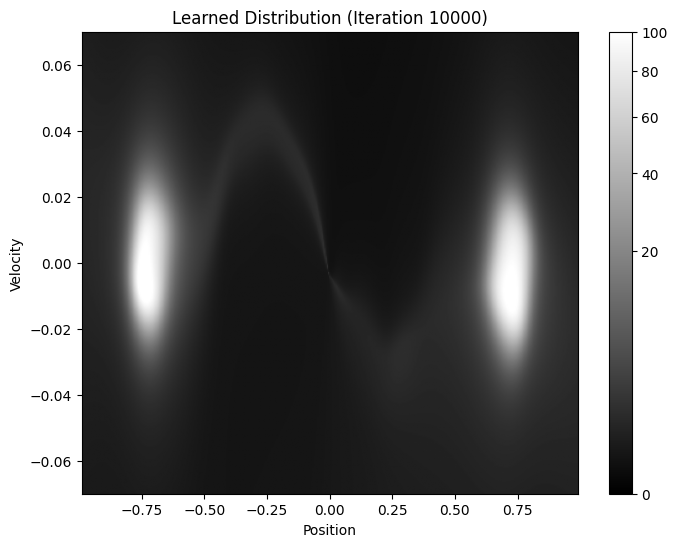

Iteration 10000/10000: L_est=0.000011 | E_m[w]≈1.130 | λ=1.0181
--- Weight Check (Iter 10000): Avg Bowl Weight = 2.6445 | Avg Bridge Weight = 0.0849 ---

Training complete. Metrics saved to training_metrics.csv


In [16]:
history, density = train(T=10000, N=15000, B=8000, print_every=50, visualize_every=200,
                         gamma=0.99, lr=1e-3, lambda_norm_scale=1.0)

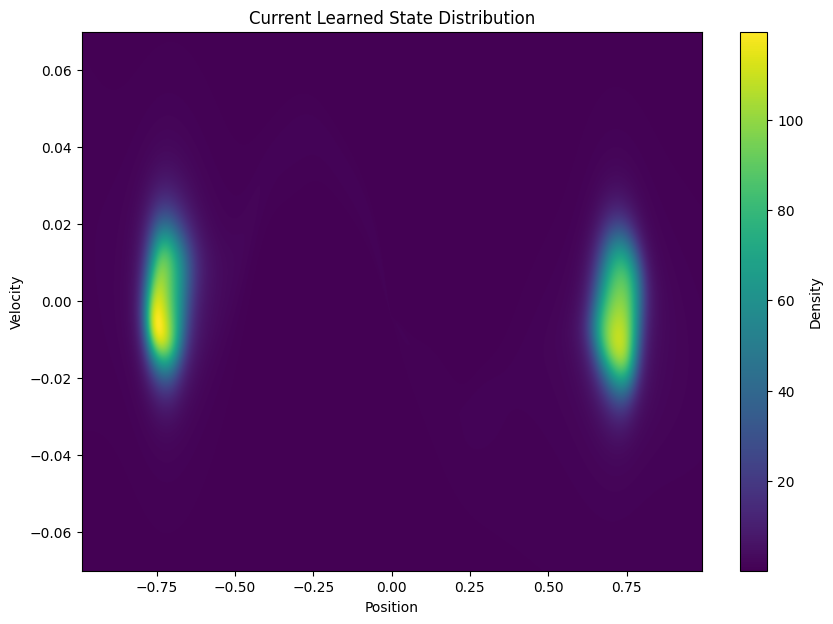

In [17]:
pos_grid = torch.linspace(min_position, max_position, 1001, device=device)
vel_grid = torch.linspace(-max_speed, max_speed, 1001, device=device)
P, V = torch.meshgrid(pos_grid, vel_grid, indexing='ij')
grid_states = torch.stack((P.flatten(), V.flatten()), dim=1)

# Compute density values
with torch.no_grad():
    d_values = torch.exp(density.log_prob(grid_states)).cpu().numpy().reshape(1001, 1001)

# Plot
fig, ax = plt.subplots(figsize=(10, 7))
im = ax.imshow(
    d_values.T, 
    extent=[min_position, max_position, -max_speed, max_speed],
    origin='lower', 
    cmap='viridis', 
    aspect='auto'
)
plt.colorbar(im, ax=ax, label='Density')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_title('Current Learned State Distribution')
plt.show()